In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

# Step 1: Read the CSV data
# Replace 'your_data.csv' with your actual CSV file path
data = pd.read_csv('Water_Count.csv')

# Step 2: Combine 'Date' and 'Time' into a single datetime column
# Adjusting the format to match your data (mm/dd/yyyy hh:mm)
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%m/%d/%Y %H:%M')

# Step 3: Sort data by datetime
data.sort_values('Datetime', inplace=True)

# Step 4: Reset index
data.reset_index(drop=True, inplace=True)


In [4]:
# Step 5: Convert datetime to numerical format (seconds since first measurement)
data['Seconds Since Start'] = (data['Datetime'] - data['Datetime'].iloc[0]).dt.total_seconds()

# Step 6: Prepare data for regression
X = data['Seconds Since Start'].values.reshape(-1, 1)  # Independent variable
y = data['Count'].values  # Dependent variable

# Step 7: Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [5]:
# Step 8: Predict when the counter will reach 69,420
target_count = 69420

# Extract model parameters
m = model.coef_[0]
b = model.intercept_

# Calculate the time in seconds when the counter reaches the target
seconds_to_target = (target_count - b) / m

# Convert seconds to datetime
target_datetime = data['Datetime'].iloc[0] + pd.to_timedelta(seconds_to_target, unit='s')

print(f"The counter is predicted to reach {target_count} on {target_datetime.strftime('%Y-%m-%d %H:%M')}")

# Step 9: Calculate prediction intervals
# Calculate residuals
predictions = model.predict(X)
residuals = y - predictions

# Degrees of freedom
df = len(y) - 2  # Number of observations minus number of parameters

# Residual standard error
s_e = np.sqrt(np.sum(residuals**2) / df)

# t-statistic for 95% confidence
t = stats.t.ppf(0.975, df)

# Standard error of the predicted x (time)
mean_X = np.mean(X)
Sxx = np.sum((X - mean_X)**2)
s_x = s_e / np.abs(m) * np.sqrt(1 + (1/len(X)) + ((seconds_to_target - mean_X)**2 / Sxx))

# Prediction interval for x (seconds_to_target)
delta_seconds = t * s_x

# Lower and upper bounds for the predicted time in seconds
seconds_lower = seconds_to_target - delta_seconds
seconds_upper = seconds_to_target + delta_seconds

# Convert to datetime
datetime_lower = data['Datetime'].iloc[0] + pd.to_timedelta(seconds_lower, unit='s')
datetime_upper = data['Datetime'].iloc[0] + pd.to_timedelta(seconds_upper, unit='s')

print(f"With 95% confidence, the counter will reach {target_count} between {datetime_lower.strftime('%Y-%m-%d %H:%M')} and {datetime_upper.strftime('%Y-%m-%d %H:%M')}")

The counter is predicted to reach 69420 on 2024-11-19 18:11
With 95% confidence, the counter will reach 69420 between 2024-11-14 23:28 and 2024-11-24 12:55


In [6]:
# Step 10: Adjust for weekends
def adjust_for_weekend(dt):
    if dt.weekday() == 5:  # Saturday
        return dt + timedelta(days=2)
    elif dt.weekday() == 6:  # Sunday
        return dt + timedelta(days=1)
    else:
        return dt

# Adjust predicted datetime
adjusted_target_datetime = adjust_for_weekend(target_datetime)
adjusted_datetime_lower = adjust_for_weekend(datetime_lower)
adjusted_datetime_upper = adjust_for_weekend(datetime_upper)

print(f"Adjusted predicted date (if falls on weekend): {adjusted_target_datetime.strftime('%Y-%m-%d %H:%M')}")
print(f"Adjusted minimum date: {adjusted_datetime_lower.strftime('%Y-%m-%d %H:%M')}")
print(f"Adjusted maximum date: {adjusted_datetime_upper.strftime('%Y-%m-%d %H:%M')}")

Adjusted predicted date (if falls on weekend): 2024-11-19 18:11
Adjusted minimum date: 2024-11-14 23:28
Adjusted maximum date: 2024-11-25 12:55


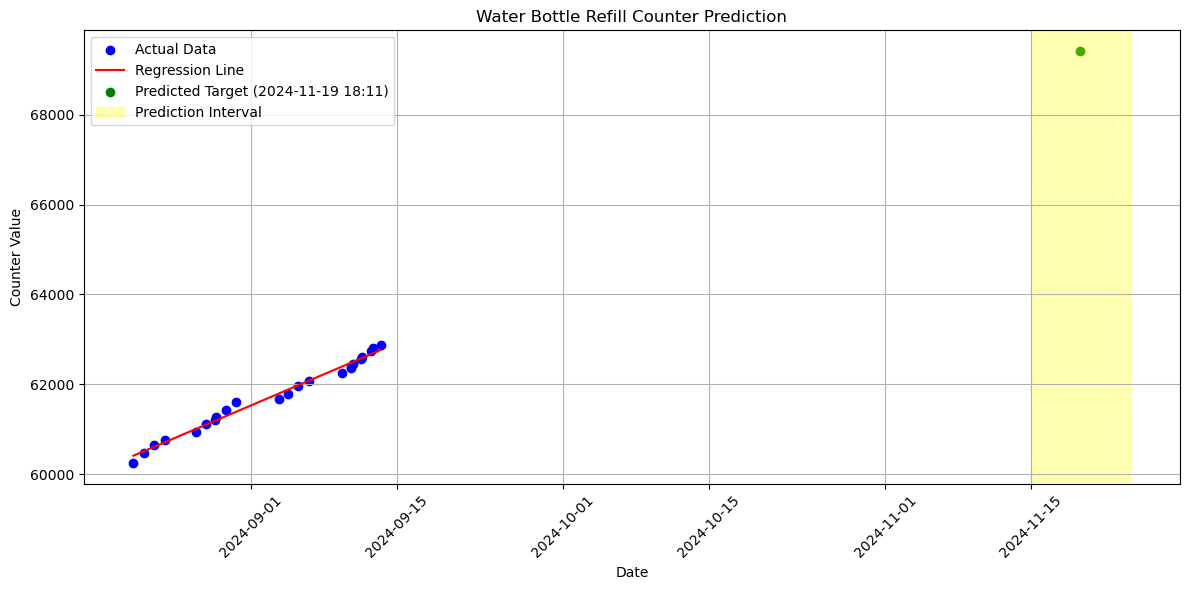

In [7]:
# Step 11: Plotting
plt.figure(figsize=(12,6))

# Plot actual data points
plt.scatter(data['Datetime'], y, color='blue', label='Actual Data')

# Plot regression line
plt.plot(data['Datetime'], predictions, color='red', label='Regression Line')

# Plot the predicted target point
plt.scatter(target_datetime, target_count, color='green', label=f'Predicted Target ({target_datetime.strftime("%Y-%m-%d %H:%M")})')

# Plot prediction interval as a shaded area
plt.axvspan(datetime_lower, datetime_upper, color='yellow', alpha=0.3, label='Prediction Interval')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Counter Value')
plt.title('Water Bottle Refill Counter Prediction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()